In [ ]:
# libraries
library(Seurat)
library(tidyverse)
library(igraph)
require(circlize)
library(R.utils)
library(data.table) #to read gz file

In [ ]:
sessionInfo()

In [ ]:
input_dir <- "../../../../data_preprocessing/Lasry/2.filtering/outs/"

In [ ]:
# # load counts
# print("load counts")

counts <- fread(paste0(input_dir,"counts_lognorm.csv.gz"), header = TRUE,check.names=FALSE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]

In [ ]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table(paste0(input_dir,"anno_cells_norm.txt")
                         ,sep = "\t"
                         # ,row.names = 2
                         ,header = TRUE
                         ,check.names=FALSE
                         )
# print(str(anno_cells))

In [ ]:
#set rownames of annotation to cell_ids
rownames(anno_cells) <- anno_cells$cell

#set colnames of counts to cell_ids
colnames(counts) <- rownames(anno_cells)

In [8]:
avg_expression <- rowMeans(counts)

In [9]:
gene_names <- rownames(counts)

In [10]:
avg_expr_table <- data.frame(Gene = gene_names, AverageExpression = avg_expression)

In [11]:
case <- anno_cells$health_status == "AML"
case_idx <- rownames(anno_cells)[case]

In [12]:
avg_expression_case <- rowMeans(counts[,case_idx])
# gene_names <- rownames(counts[,case_idx])
# avg_expr_table_case <- data.frame(Gene = gene_names, AverageExpression = avg_expression)

In [13]:
control <- anno_cells$health_status == "healthy"
control_idx <- rownames(anno_cells)[control]

In [14]:
avg_expression_control <- rowMeans(counts[,control_idx])

In [15]:
avg_expr_table$control <- avg_expression_control

In [16]:
avg_expr_table$case <- avg_expression_case

In [17]:
#create a Seurat object
srt=CreateSeuratObject(counts=counts, meta.data=anno_cells)

In [18]:
#peek into the number of cells for case/control
srt@meta.data$health_status %>% table()

.
    AML healthy 
  21311   25391 

In [19]:
#peek into the number of cell types
srt@meta.data$cell_type %>% table()

.
    B    DC   Ery  Gran  HSPC  Mono    NK     T 
 4765  1634  1674  2332  3169 18004  3078 12046 

In [20]:
#set the indent to cell_type
Idents(srt) <- "cell_type"

In [25]:
#set colnames of counts to cell_ids
colnames(log1p_count_matrix) <- rownames(anno_cells)
#create a Seurat object
srt_log=CreateSeuratObject(counts=log1p_count_matrix, meta.data=anno_cells)
#peek into the number of cells for case/control
srt_log@meta.data$health_status %>% table()
#set the indent to cell_type
Idents(srt_log) <- "cell_type"

.
    AML healthy 
  21311   25391 

In [26]:
# initialize empty vector for storing DEGs
DEGs <- c()

# iterate over each unique cell type 
for (cell_type in unique(srt@meta.data$cell_type)) {
  
  # subset Seurat object to only include cells of current cell type
  seurat_obj_receiver <- subset(srt, idents = cell_type)
  
  # set cell identity using the "health_status" feature
  seurat_obj_receiver <- SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["health_status"]])
  
  # specify the two conditions to compare
  condition_oi <- "AML"
  condition_reference <- "healthy" 
  
#   find differentially expressed genes between the two conditions
  DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
                                   # test.use = "t",
                                   ident.1 = condition_oi, 
                                   ident.2 = condition_reference, 
                                   min.pct = 0.10) %>%
    # convert row names to a separate "gene" column
    rownames_to_column("gene")
    
#     DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
#                                    slot = "data",
#                                    ident.1 = condition_oi, 
#                                    ident.2 = condition_reference, 
#                                    min.pct = -Inf,
#                                    thresh.use = 0,
#                                    logfc.threshold = -Inf,
#                                    min.cells.feature = 1, min.cells.group = 1) %>% rownames_to_column("gene")
    
    
    
  
  # add cell type information to the DEG table
  DE_table_receiver <- data.frame(cluster = cell_type, DE_table_receiver)
  
  # filter DEGs based on statistical significance and fold change threshold
  DE_table_receiver <- DE_table_receiver %>% 
    filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25)
  
  # print cell type and number of DEGs found
  print(cell_type)
  print("number of genes in the cell type")
  print(length(row.names(seurat_obj_receiver@assays$RNA@data)))
  print("number of genes output from DE")
  print(nrow(DE_table_receiver))
  
  # append DEGs to the vector of all DEGs
  DEGs <- rbind(DEGs, DE_table_receiver)
}

[1] "Mono"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1070
[1] "Gran"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1170
[1] "T"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 697
[1] "NK"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 647
[1] "B"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1380
[1] "HSPC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1207
[1] "Ery"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1374
[1] "DC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 735


In [27]:
table(DEGs$cluster)


   B   DC  Ery Gran HSPC Mono   NK    T 
1380  735 1374 1170 1207 1070  647  697 

In [28]:
# initialize empty vector for storing DEGs
DEGs <- c()

# iterate over each unique cell type 
for (cell_type in unique(srt_log@meta.data$cell_type)) {
  
  # subset Seurat object to only include cells of current cell type
  seurat_obj_receiver <- subset(srt_log, idents = cell_type)
  
  # set cell identity using the "health_status" feature
  seurat_obj_receiver <- SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["health_status"]])
  
  # specify the two conditions to compare
  condition_oi <- "AML"
  condition_reference <- "healthy" 
  
#   find differentially expressed genes between the two conditions
  DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
                                   # test.use = "t",
                                   ident.1 = condition_oi, 
                                   ident.2 = condition_reference, 
                                   min.pct = 0.10) %>%
    # convert row names to a separate "gene" column
    rownames_to_column("gene")
    
#     DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
#                                    slot = "data",
#                                    ident.1 = condition_oi, 
#                                    ident.2 = condition_reference, 
#                                    min.pct = -Inf,
#                                    thresh.use = 0,
#                                    logfc.threshold = -Inf,
#                                    min.cells.feature = 1, min.cells.group = 1) %>% rownames_to_column("gene")
    
    
    
  
  # add cell type information to the DEG table
  DE_table_receiver <- data.frame(cluster = cell_type, DE_table_receiver)
  
  # filter DEGs based on statistical significance and fold change threshold
  DE_table_receiver <- DE_table_receiver %>% 
    filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25)
  
  # print cell type and number of DEGs found
  print(cell_type)
  print("number of genes in the cell type")
  print(length(row.names(seurat_obj_receiver@assays$RNA@data)))
  print("number of genes output from DE")
  print(nrow(DE_table_receiver))
  
  # append DEGs to the vector of all DEGs
  DEGs <- rbind(DEGs, DE_table_receiver)
}

[1] "Mono"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 386
[1] "Gran"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 337
[1] "T"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 216
[1] "NK"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 472
[1] "B"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 297
[1] "HSPC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 452
[1] "Ery"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1082
[1] "DC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 239


In [30]:
table(DEGs$cluster)


   B   DC  Ery Gran HSPC Mono   NK    T 
 297  239 1082  337  452  386  472  216 

In [31]:
# initialize empty vector for storing DEGs
DEGs <- c()

# iterate over each unique cell type 
for (cell_type in unique(srt@meta.data$cell_type)) {
  
  # subset Seurat object to only include cells of current cell type
  seurat_obj_receiver <- subset(srt, idents = cell_type)
  
  # set cell identity using the "health_status" feature
  seurat_obj_receiver <- SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["health_status"]])
  
  # specify the two conditions to compare
  condition_oi <- "AML"
  condition_reference <- "healthy" 
  
#   find differentially expressed genes between the two conditions
  DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
                                   test.use = "t",
                                   ident.1 = condition_oi, 
                                   ident.2 = condition_reference, 
                                   min.pct = 0.10) %>%
    # convert row names to a separate "gene" column
    rownames_to_column("gene")
    
#     DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
#                                    slot = "data",
#                                    ident.1 = condition_oi, 
#                                    ident.2 = condition_reference, 
#                                    min.pct = -Inf,
#                                    thresh.use = 0,
#                                    logfc.threshold = -Inf,
#                                    min.cells.feature = 1, min.cells.group = 1) %>% rownames_to_column("gene")
    
    
    
  
  # add cell type information to the DEG table
  DE_table_receiver <- data.frame(cluster = cell_type, DE_table_receiver)
  
  # filter DEGs based on statistical significance and fold change threshold
  DE_table_receiver <- DE_table_receiver %>% 
    filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25)
  
  # print cell type and number of DEGs found
  print(cell_type)
  print("number of genes in the cell type")
  print(length(row.names(seurat_obj_receiver@assays$RNA@data)))
  print("number of genes output from DE")
  print(nrow(DE_table_receiver))
  
  # append DEGs to the vector of all DEGs
  DEGs <- rbind(DEGs, DE_table_receiver)
}

[1] "Mono"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1119
[1] "Gran"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1215
[1] "T"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 779
[1] "NK"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 673
[1] "B"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1407
[1] "HSPC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1582
[1] "Ery"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1627
[1] "DC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 781


In [32]:
table(DEGs$cluster)


   B   DC  Ery Gran HSPC Mono   NK    T 
1407  781 1627 1215 1582 1119  673  779 

In [90]:
# initialize empty vector for storing DEGs
DEGs <- c()

# iterate over each unique cell type 
for (cell_type in unique(srt@meta.data$cell_type)) {
  
  # subset Seurat object to only include cells of current cell type
  seurat_obj_receiver <- subset(srt, idents = cell_type)
  
  # set cell identity using the "health_status" feature
  seurat_obj_receiver <- SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["health_status"]])
  
  # specify the two conditions to compare
  condition_oi <- "AML"
  condition_reference <- "healthy" 
  
#   find differentially expressed genes between the two conditions
  DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
                                   test.use = "t", slot = "data",
                                   ident.1 = condition_oi, 
                                   ident.2 = condition_reference, 
                                   min.pct = 0.10) %>%
    # convert row names to a separate "gene" column
    rownames_to_column("gene")
    
#     DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
#                                    slot = "data",
#                                    ident.1 = condition_oi, 
#                                    ident.2 = condition_reference, 
#                                    min.pct = -Inf,
#                                    thresh.use = 0,
#                                    logfc.threshold = -Inf,
#                                    min.cells.feature = 1, min.cells.group = 1) %>% rownames_to_column("gene")
    
    
    
  
  # add cell type information to the DEG table
  DE_table_receiver <- data.frame(cluster = cell_type, DE_table_receiver)
  
  # filter DEGs based on statistical significance and fold change threshold
  DE_table_receiver <- DE_table_receiver %>% 
    filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25)
  
  # print cell type and number of DEGs found
  print(cell_type)
  print("number of genes in the cell type")
  print(length(row.names(seurat_obj_receiver@assays$RNA@data)))
  print("number of genes output from DE")
  print(nrow(DE_table_receiver))
  
  # append DEGs to the vector of all DEGs
  DEGs <- rbind(DEGs, DE_table_receiver)
}

[1] "Mono"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1119
[1] "Gran"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1215
[1] "T"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 779
[1] "NK"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 673
[1] "B"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1407
[1] "HSPC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1582
[1] "Ery"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1627
[1] "DC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 781


In [91]:
table(DEGs$cluster)


   B   DC  Ery Gran HSPC Mono   NK    T 
1407  781 1627 1215 1582 1119  673  779 

In [87]:
# initialize empty vector for storing DEGs
DEGs <- c()

# iterate over each unique cell type 
for (cell_type in unique(srt@meta.data$cell_type)) {
  
  # subset Seurat object to only include cells of current cell type
  seurat_obj_receiver <- subset(srt, idents = cell_type)
  
  # set cell identity using the "health_status" feature
  seurat_obj_receiver <- SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["health_status"]])
  
  # specify the two conditions to compare
  condition_oi <- "AML"
  condition_reference <- "healthy" 
  
#   find differentially expressed genes between the two conditions
  DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
                                   test.use = "t", slot = "counts",
                                   ident.1 = condition_oi, 
                                   ident.2 = condition_reference, 
                                   min.pct = 0.10) %>%
    # convert row names to a separate "gene" column
    rownames_to_column("gene")
    
#     DE_table_receiver <- FindMarkers(object = seurat_obj_receiver, 
#                                    slot = "data",
#                                    ident.1 = condition_oi, 
#                                    ident.2 = condition_reference, 
#                                    min.pct = -Inf,
#                                    thresh.use = 0,
#                                    logfc.threshold = -Inf,
#                                    min.cells.feature = 1, min.cells.group = 1) %>% rownames_to_column("gene")
    
    
    
  
  # add cell type information to the DEG table
  DE_table_receiver <- data.frame(cluster = cell_type, DE_table_receiver)
  
  # filter DEGs based on statistical significance and fold change threshold
  DE_table_receiver <- DE_table_receiver %>% 
    filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25)
  
  # print cell type and number of DEGs found
  print(cell_type)
  print("number of genes in the cell type")
  print(length(row.names(seurat_obj_receiver@assays$RNA@data)))
  print("number of genes output from DE")
  print(nrow(DE_table_receiver))
  
  # append DEGs to the vector of all DEGs
  DEGs <- rbind(DEGs, DE_table_receiver)
}

[1] "Mono"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 386
[1] "Gran"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 337
[1] "T"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 216
[1] "NK"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 472
[1] "B"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 297
[1] "HSPC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 453
[1] "Ery"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 1112
[1] "DC"
[1] "number of genes in the cell type"
[1] 15770
[1] "number of genes output from DE"
[1] 242


In [88]:
table(DEGs$cluster)


   B   DC  Ery Gran HSPC Mono   NK    T 
 297  242 1112  337  453  386  472  216 

In [92]:
table(DEGs$cluster)


   B   DC  Ery Gran HSPC Mono   NK    T 
1407  781 1627 1215 1582 1119  673  779 

In [27]:
write.csv(table(DEGs$cluster), "DEGs_numbers.csv")

In [ ]:
write.csv(DEGs, "DEG_significant_table.csv")

In [57]:
write.csv(DEGs, "DEG_table.csv")

In [46]:
table(anno_cells$cell_type)


    B    DC   Ery  Gran  HSPC  Mono    NK     T 
 4765  1634  1674  2332  3169 18004  3078 12046 

In [47]:
anno_DC <- anno_cells[anno_cells$cell_type=="DC",]

In [52]:
anno_DC_control <- anno_DC[anno_DC$health_status=="healthy",]

In [53]:
anno_DC_case <- anno_DC[anno_DC$health_status=="AML",]

In [59]:
counts_control <- counts[colnames(counts) %in% rownames(anno_DC_control)]

In [58]:
counts_case <- counts[colnames(counts) %in% rownames(anno_DC_case)]

In [49]:
table(anno_DC$health_status)


    AML healthy 
    389    1245 

In [60]:
mean_healthy <- rowMeans(counts_healthy)
mean_case <- rowMeans(counts_case)

In [61]:
log2FC <- mean_case - mean_healthy

In [101]:
log2FC["ANKRD28"]

ANKRD28 
0.6602044

In [104]:
typeof(log2FC)

[1] "double"

In [105]:
DEGs_DC <- DEGs[DEGs$cluster=="DC",]

In [107]:
manual_log2FC_df <- data.frame(gene = names(log2FC), log2FC_manual = log2FC, stringsAsFactors = FALSE)

In [111]:
comparison_df <- merge(manual_log2FC_df, DE_table_receiver, by = "gene")

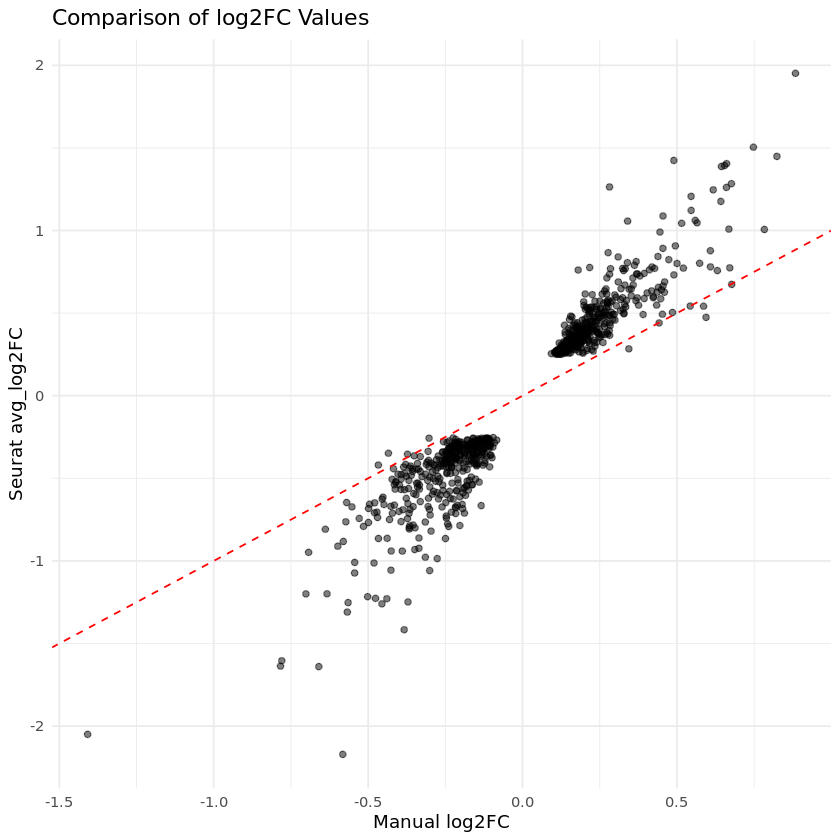

In [112]:
ggplot(comparison_df, aes(x = log2FC_manual, y = avg_log2FC)) +
  geom_point(alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(x = "Manual log2FC", y = "Seurat avg_log2FC", title = "Comparison of log2FC Values") +
  theme_minimal()

In [113]:
comparison_df$difference = comparison_df$log2FC_manual - comparison_df$avg_log2FC

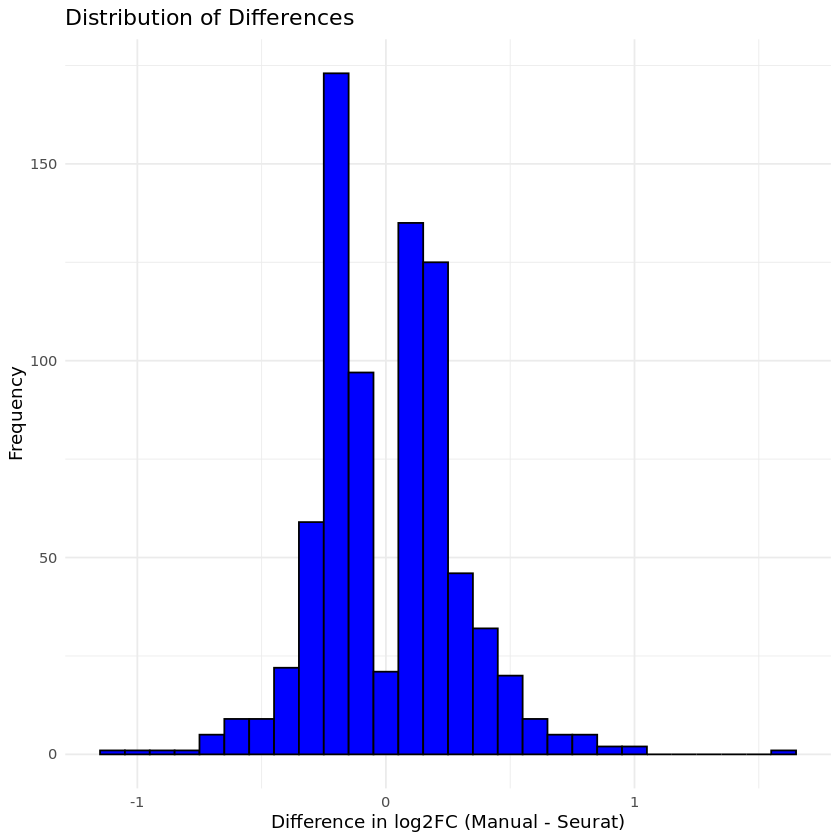

In [114]:
# diff distribtuion

ggplot(comparison_df, aes(x = difference)) +
  geom_histogram(binwidth = 0.1, fill = "blue", color = "black") +
  labs(x = "Difference in log2FC (Manual - Seurat)", y = "Frequency", title = "Distribution of Differences") +
  theme_minimal()

In [115]:
comparison_long <- comparison_df %>%
  select(gene, log2FC_manual, avg_log2FC) %>%
  pivot_longer(cols = -gene, names_to = "method", values_to = "log2FC_value") %>%
  mutate(method = ifelse(method == "log2FC_manual", "Manual", "Seurat"))

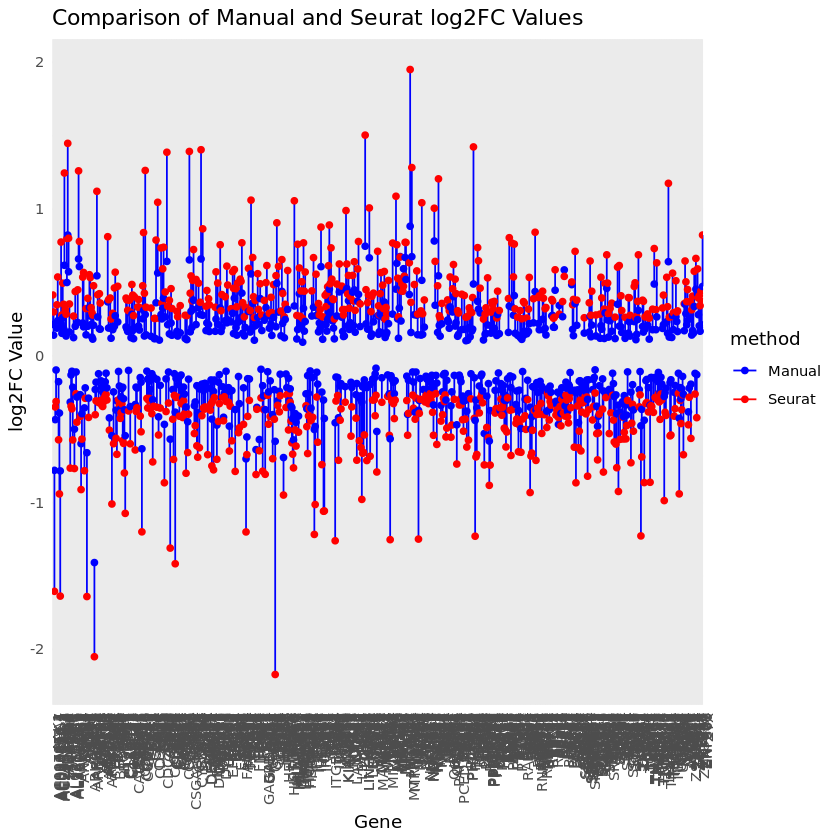

In [116]:
ggplot(comparison_long, aes(x = gene, y = log2FC_value, group = gene, color = method)) +
  geom_line() + # This draws lines between Manual and Seurat values for each gene
  geom_point() + # This plots the log2FC values
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "Gene", y = "log2FC Value", title = "Comparison of Manual and Seurat log2FC Values") +
  scale_color_manual(values = c("Manual" = "blue", "Seurat" = "red"))

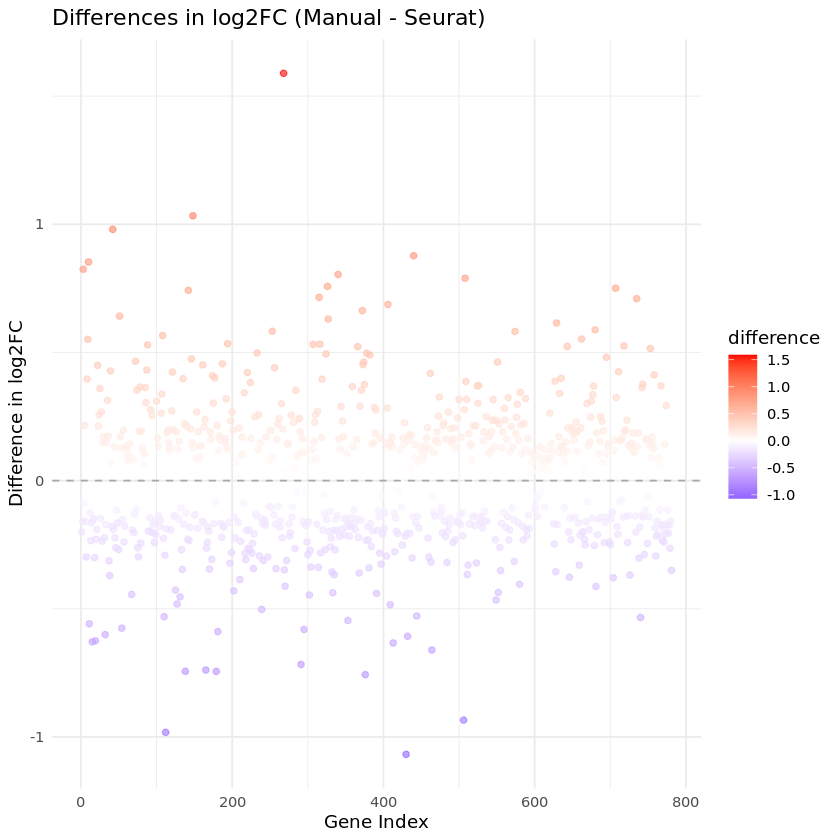

In [120]:
comparison_df$gene_index <- seq_along(comparison_df$difference)

ggplot(comparison_df, aes(x = gene_index, y = difference)) +
  geom_point(aes(color = difference), alpha = 0.6) + 
  scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "darkgray") +
  labs(title = "Differences in log2FC (Manual - Seurat)",
       x = "Gene Index",
       y = "Difference in log2FC")

In [2]:
FindMarkers.DimReduc

ERROR: Error in FindMarkers.DimReduc(): could not find function "FindMarkers.DimReduc"
